In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 21 11:51:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   66C    P0              32W /  72W |    363MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

Тестова задача. Домен [0,2], нульові граничні умови, початкова умова визначається з точного розв'язку [Arora, Geeta, Mishra, Shubham, Emaifar, Homan, Khademi, Masoumeh (2023) Numerical Simulation and Dynamics of Burgers’ Equation Using the Modified Cubic B-Spline Differential Quadrature Method. Discrete Dynamics in Nature and Society Volume 2023, Article ID 5102374, 8 pages
https://doi.org/10.1155/2023/5102374
]:

$\displaystyle u(x,t) =  2 \pi \nu \frac{\sin(\gamma)e^\beta+4\sin(2\gamma)e^{-4\beta}}{4+\cos(\gamma)e^\beta+2\cos(2\gamma)e^{-4\beta}},$

де $\gamma=\pi x$, $\beta=-\pi^2 \nu^2 t$

In [ ]:
# x_max = 1
# t_max = 4

#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1
        self.t_max = 4

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.nu = 0.01
        self.epoch = 2000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        t0 = torch.exp(torch.tensor([1/(8*self.nu)]))

        y_ic  = ic[:,0] / (1 + torch.sqrt(1/t0)*torch.exp((ic[:,0]**2)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

100 0.004060676787048578
0.00018646431271918118
0.003874212270602584
200 0.00394028052687645
0.0002006643480854109
0.003739616135135293
300 0.003841687459498644
0.00022480842017102987
0.0036168789956718683
400 0.003741985885426402
0.00024411798221990466
0.0034978678449988365
500 0.00361625081859529
0.0002554098318796605
0.0033608409576117992
600 0.0034258298110216856
0.0002536604006309062
0.00317216943949461
700 0.0030850491020828485
0.00022545379761140794
0.0028595952317118645
800 0.0024458379484713078
0.00015138712478801608
0.0022944507654756308
900 0.0018143041525036097
0.00012752875045407563
0.0016867753583937883
1000 0.0016753154341131449
0.00020049192244186997
0.001474823453463614
1100 0.0015730219893157482
0.00019901762425433844
0.0013740044087171555
1200 0.0013946073595434427
0.00018482105224393308
0.0012097862781956792
1300 0.0010910406708717346
0.00015505572082474828
0.0009359848918393254
1400 0.0007620152900926769
0.00012532096297945827
0.0006366943125613034
1500 0.000539910

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 3.9800],
        [1.0000, 3.9900],
        [1.0000, 4.0000]], device='cuda:0')

In [ ]:
X.shape

torch.Size([30401, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(101, 301)

In [ ]:
y_pred

array([[ 7.4225850e-04,  6.7156740e-04,  6.0290284e-04, ...,
         1.8471666e-04,  2.0653196e-04,  2.2882409e-04],
       [ 1.0276141e-02,  1.0107817e-02,  9.9425931e-03, ...,
         2.5475640e-03,  2.5636572e-03,  2.5801081e-03],
       [ 1.9863071e-02,  1.9596638e-02,  1.9334855e-02, ...,
         4.9150605e-03,  4.9255509e-03,  4.9363989e-03],
       ...,
       [-4.1184947e-05, -1.4143996e-04, -2.2870116e-04, ...,
         3.1646430e-02,  3.1745732e-02,  3.1841695e-02],
       [ 1.3917871e-04,  3.5185367e-06, -1.1628680e-04, ...,
         1.6943814e-02,  1.6990485e-02,  1.7034533e-02],
       [ 3.9726682e-04,  2.2190996e-04,  6.4672902e-05, ...,
         1.8591899e-03,  1.8398184e-03,  1.8185396e-03]], dtype=float32)

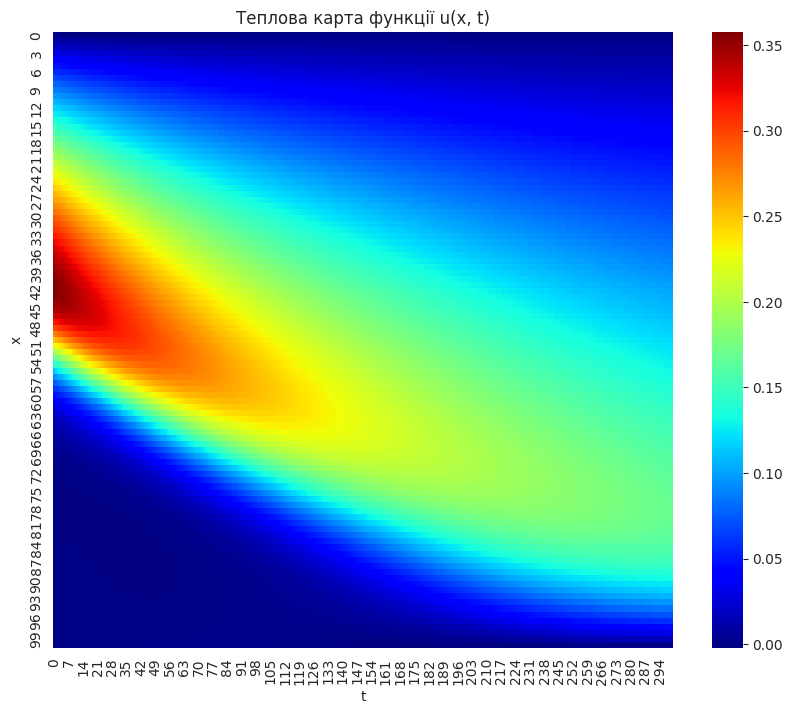

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



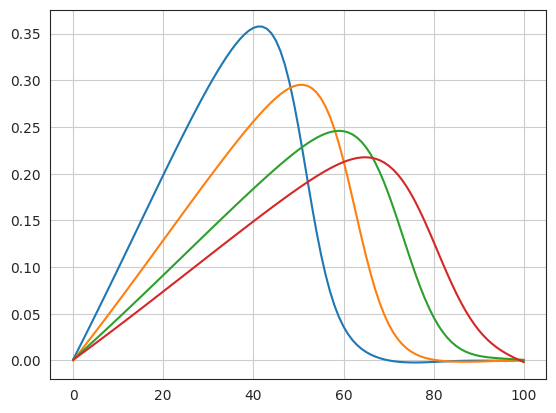

In [ ]:

plt.plot(y_pred[:,0])
plt.plot(y_pred[:,50])
plt.plot(y_pred[:,110])
plt.plot(y_pred[:,160])


plt.grid(True)
plt.show()

In [ ]:
t[50]

tensor(1.5000)

In [ ]:
x[50]

tensor(0.5000)

Порівняння з іншими результатами